In [1]:
from utils.dawnfrb import FRBInfo
from utils.dawnplot import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/opt/conda/envs/umap/lib
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))
from umap.parametric_umap import ParametricUMAP
catalog = FRBInfo(
    '/home/jovyan/work/chime_data/21.0007/',
    '/home/jovyan/work/chime_data/23.0004/',
    remove_duplicates=True
)

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/opt/conda/envs/umap/lib
[]


In [2]:
ts = catalog['ts']

In [3]:
before=[]
after=[]
for c in ts:
    a=np.argmax(c)
    before.append(a)
    after.append(c.shape[0]-a)

In [4]:
truncate_width = 100
padded_ts=[]
for c in ts:
    a=np.argmax(c)
    p=np.pad(c,(max(before)-a,max(after)-(c.shape[0]-a)),'constant',constant_values=0)
    # padded_ts.append(p[max(before)-truncate_width//2:max(before)+truncate_width//2])
    padded_ts.append(p)

padded_ts_normed = [series / np.max(series) for series in padded_ts]

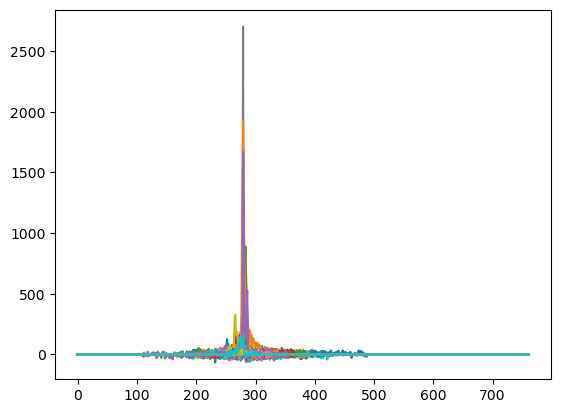

In [5]:
for i in padded_ts[300:590]:
    plt.plot(i)

In [6]:
shape = (len(padded_ts[0]),1)
n_components = 2
encoder = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=shape),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_components, activation='linear')
], name='encoder')

plot = BokehInterface(
    views=[
        # EmbeddingView(
        #     title='raw_ts_para',
        #     data=timeSeries,
        #     reducer=ParametricUMAP(
        #         n_training_epochs=2,
        #         verbose=True,
        #     ),
        # ),
        EmbeddingView(
            title='padded_aligned_truncated100_ts_para_cnn',
            data=padded_ts,
            reducer=ParametricUMAP(
                encoder=encoder,
                dims=shape,
                verbose=True,
                n_training_epochs=2
            ),
        ),
        EmbeddingView(
            title='padded_aligned_truncated100_ts_normed_para_cnn',
            data=padded_ts_normed,
            reducer=ParametricUMAP(
                encoder=encoder,
                dims=shape,
                verbose=True,
                n_training_epochs=2
            ),
        ),
    ],
    plot_elements=[
        ColorTooltipData(
            title='width_ms',
            data=[i*1000 for i in catalog['width_fitb']],
        ),
        ColorTooltipData(
            title='dm',
            data=catalog['dm_fitb'],
        ),
        ColorTooltipData(
            title='n_subbursts',
            data=catalog['n_subbursts'],
        ),
        ColorMap(
            title='scattering_ms',
            data=[i*1000 for i in catalog['scat_time']],
        ),
        ColorMap(
            title='scatterfit',
            data=["✔️" if i else "❌" for i in catalog['scatterfit']],
            high_transparent=False,
        ),
        ColorMap(
            title='known_repeater',
            data=["✔️" if rp != -9999.0 else "❌" for rp in catalog['repeater_name']],
            high_transparent=False,
        ),
        ColorMap(
            title='ts_embedding_label',
            data=[str(l) for l in catalog['ts_embedding_label']],
        ),
        TooltipData(
            title='tns_name',
            data=catalog['tns_name'],
        ),
        TooltipGraph(
            padded_ts,
            title='padded_aligned_truncated100_ts',
        ),
    ],
)

ParametricUMAP(dims=(762, 1), encoder=<keras.engine.sequential.Sequential object at 0x7fda8520a6a0>, n_training_epochs=2, optimizer=<keras.optimizer_v2.adam.Adam object at 0x7fda781c42b0>)
Sat Oct 21 09:00:50 2023 Construct fuzzy simplicial set
Sat Oct 21 09:00:51 2023 Finding Nearest Neighbors
Sat Oct 21 09:00:52 2023 Finished Nearest Neighbor Search
Sat Oct 21 09:00:54 2023 Construct embedding
Epoch 1/20
170/348 [=============>................] - ETA: 13:25 - loss: 0.2998

KeyboardInterrupt: 

In [ ]:
plot.PLOT_DF['marker'] = ['star' if rp != -9999.0 else 'circle' for rp in catalog['repeater_name']]
plot.PLOT_DF['size'] = [20 if rp != -9999.0 else 6 for rp in catalog['repeater_name']]
plot.init_plot_elements()
plot.plotPoints.glyph.size='size'
plot.plotPoints.glyph.marker = 'marker'
# plot.plotPoints.glyph.line_alpha=1
plot.plotPoints.glyph.line_color='black'
# plot.plotPoints.glyph.fill_alpha=1
# plot.plotPoints.glyph.line_width='outline'
plot.show()